Mirella Glowinska
C00275764
Datset source: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
Tutrial: https://www.analyticsvidhya.com/blog/2021/06/image-processing-using-cnn-a-beginners-guide/

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

IMG_SIZE = (32, 32)
BATCH_SIZE = 32
EPOCHS = 15

def load_subset(directory, max_samples_per_class=20000):
    classes = ['real', 'fake']
    image_paths = []
    labels = []
    for idx, cls in enumerate(classes):
        cls_dir = os.path.join(directory, cls)
        files = os.listdir(cls_dir)[:max_samples_per_class]
        for f in files:
            image_paths.append(os.path.join(cls_dir, f))
            # 0 - real
            # 1 - fake
            labels.append(idx)  
    return image_paths, labels

train_directory = '../datasets/FakevsRealImages/train'
test_directory = '../datasets/FakevsRealImages/test'

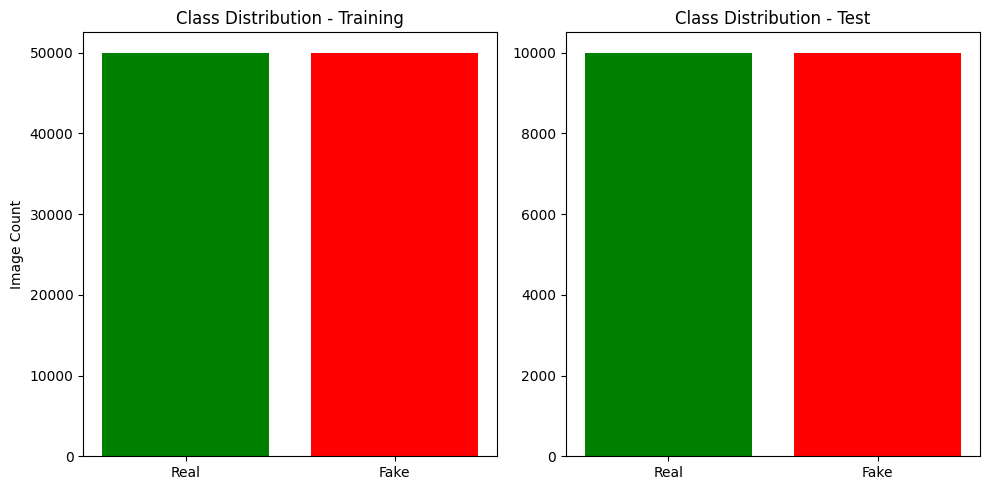


Training set statistics
- Real: 50000 images
- Fake: 50000 images

Test set statistics
- Real: 10000 images
- Fake: 10000 images


In [16]:
def count_images(directory):
    classes = ['real', 'fake']
    counts = {'real': 0, 'fake': 0}
    for cls in classes:
        cls_dir = os.path.join(directory, cls)
        if not os.path.exists(cls_dir):
            print(f"Directory {cls_dir} does not exist")
            continue
            
        valid_extensions = ('.jpg', '.jpeg', '.png')
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith(valid_extensions)]
        counts[cls] = len(files)
        
    return counts

train_counts = count_images(train_directory)
test_counts = count_images(test_directory)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(['Real', 'Fake'], [train_counts['real'], train_counts['fake']], color=['green', 'red'])
plt.title('Class Distribution - Training')
plt.ylabel('Image Count')

plt.subplot(1, 2, 2)
plt.bar(['Real', 'Fake'], [test_counts['real'], test_counts['fake']], color=['green', 'red'])
plt.title('Class Distribution - Test')

plt.tight_layout()
plt.show()

print(f"\nTraining set statistics")
print(f"- Real: {train_counts['real']} images")
print(f"- Fake: {train_counts['fake']} images")

print(f"\nTest set statistics")
print(f"- Real: {test_counts['real']} images")
print(f"- Fake: {test_counts['fake']} images")

In [ ]:
train_image_paths, train_labels = load_subset(train_directory)
test_image_paths, test_labels = load_subset(test_directory)

train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    train_image_paths, train_labels, 
    test_size=0.2, 
    random_state=42,
    stratify=train_labels
)

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels))

def parse_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    # normalisation
    # 0 - black
    # 255- white
    # x = 0, / 255.0 = 0
    # x = 255, / 255.0 = 1
    image = image / 255.0  
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

train_dataset = (
    train_dataset
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(10000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    val_dataset
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

model = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

test_loss, test_acc = model.evaluate(test_dataset)
print(f'\nTest set accuracy: {test_acc:.2%}')
print(f'Test set loss: {test_loss:.4f}')

model.save('../Deployment/fake_vs_real_images.h5')

Epoch 1/15


C:\Users\Mirella\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.7112 - loss: 0.5541 - val_accuracy: 0.8393 - val_loss: 0.3632
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.8433 - loss: 0.3705 - val_accuracy: 0.8876 - val_loss: 0.2763
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.8640 - loss: 0.3239 - val_accuracy: 0.8988 - val_loss: 0.2545
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.8821 - loss: 0.2866 - val_accuracy: 0.9074 - val_loss: 0.2316
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.8890 - loss: 0.2737 - val_accuracy: 0.9093 - val_loss: 0.2299
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.8985 - loss: 0.2514 - val_accuracy: 0.9121 - val_loss: 0.2228
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.8994 - loss: 0.2466 - val_accuracy: 0.9121 - val_loss: 0.2233
Epoch 8/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9076 - loss: 0.23


Test set accuracy: 92.01%
Test set loss: 0.2077


: 